# Project: Risk Mapping of Istanbul
Cihan Ozkan - 4005674 

In this project, I aimed to identify which districts are at risk by using various features and to generate a risk map of Istanbul.

I imported pandas, numpy, seaborn and matplotlib to handle the data and create visualizations.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import unicodedata

def temizle_ilce_adi(ilce):
    if isinstance(ilce, str):
        ilce = ilce.strip().upper()  # Boşlukları sil ve büyük harfe çevir
        ilce = unicodedata.normalize('NFKD', ilce).encode('ASCII', 'ignore').decode('utf-8')  # Türkçe karakterleri dönüştür
        return ilce

I loaded the deprem_df to see past earthquakes and collect the longitude, latitude and etc. datas.

In [3]:
deprem_df = pd.read_csv("../data/depremler.csv")
deprem_df.head()

,Date,Longitude,Latitude,Depth,Type,Magnitude,Location,EventID,TimeName,TypeName,MagnitudeName
0,20/05/2025 22:36:53,28.3858,40.8150,8.16,MW,4.0,Marmara Denizi - [23.63 km] Büyükçekmece (İsta...,661816,AFAD,AFAD,AFAD
1,25/04/2025 19:33:15,28.4311,40.8558,7.01,MW,4.3,Marmara Denizi - [17.82 km] Büyükçekmece (İsta...,658727,AFAD,AFAD,AFAD
2,24/04/2025 06:19:19,28.3061,40.8411,7.00,MW,4.1,Marmara Denizi - [24.56 km] Büyükçekmece (İsta...,658424,AFAD,AFAD,AFAD
3,23/04/2025 14:12:57,28.3142,40.8333,7.02,MW,4.9,Marmara Denizi - [24.82 km] Büyükçekmece (İsta...,658188,AFAD,AFAD,AFAD
4,23/04/2025 12:46:13,28.2178,40.8506,10.01,MW,4.0,Marmara Denizi - [24.46 km] Silivri (İstanbul),658161,AFAD,AFAD,AFAD


I loaded ilceler_df to take the district datas and then I organised the district names 

In [4]:
ilceler_df = pd.read_csv("../data/istanbul_ilceleri_sablon.csv")

In [5]:
ilceler_df.style.set_sticky().set_caption("İlçe Verisi")
ilceler_df.head()

,İlçe,Ortalama Bina Yaşı,Nüfus Yoğunluğu (kişi/km²),Fay Hattına Uzaklık (km),Zemin Tipi,Geçmiş Deprem Etki Skoru,Risk Skoru (hedef)
0,Adalar,NaN,NaN,NaN,NaN,NaN,NaN
1,Arnavutköy,NaN,NaN,NaN,NaN,NaN,NaN
2,Ataşehir,NaN,NaN,NaN,NaN,NaN,NaN
3,Avcılar,NaN,NaN,NaN,NaN,NaN,NaN
4,Bağcılar,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
ilceler_listesi = ilceler_df["İlçe"].tolist()
# I got the list of district names from the template dataframe

In [7]:
etki_skorlari = {ilce: 0 for ilce in ilceler_listesi}
# I created a dictionary assigning 0 effect score to each district

In [8]:
ilceler_df.head()
list(etki_skorlari.items())[:5]

[('Adalar', 0),
 ('Arnavutköy', 0),
 ('Ataşehir', 0),
 ('Avcılar', 0),
 ('Bağcılar', 0)]

In [9]:
ilce_koord_df = pd.read_csv("../data/ilce_koordinatlar.csv", sep=";")
ilce_koord_df.head()
# I loaded district coordinates for plotting maps and calculating distances

,İlçe,Latitude,Longitude
0,Adalar,40.8708,29.1186
1,Arnavutköy,41.1853,28.7392
2,Ataşehir,40.9916,29.1270
3,Avcılar,40.9796,28.7224
4,Bağcılar,41.0390,28.8567


In [10]:
from geopy.distance import geodesic
# Measure real-world distance (in km) between two coordinates
from collections import defaultdict
# Create dictionary with default float value (0.0)

# set the districts' starting score to 0
mesafeye_dayali_skorlar = defaultdict(float)

# calculation for every earthquake
for _, deprem in deprem_df.iterrows():
    try:
        deprem_koordinat = (float(deprem["Latitude"]), float(deprem["Longitude"]))
        magnitude = deprem["Magnitude"]

        if pd.isna(magnitude):
            continue  

        for _, ilce in ilce_koord_df.iterrows():
            ilce_adi = str(ilce["İlçe"]).strip().title()
            ilce_koordinat = (ilce["Latitude"], ilce["Longitude"]) 

            mesafe_km = geodesic(deprem_koordinat, ilce_koordinat).kilometers

             # Because the length of Istanbul is 150 km
            if mesafe_km <= 150:
                etki = magnitude / (1 + mesafe_km)
                mesafeye_dayali_skorlar[ilce_adi] += etki

    except:
        pass

In [11]:
# "Etki_Skoru means Impact Score" and İlçe means District"
ilce_koord_df["Etki_Skoru"] = ilce_koord_df["İlçe"].apply(
    lambda ilce: mesafeye_dayali_skorlar.get(ilce, 0)
)
#lambda: It fetches the impact score corresponding to each district and writes it to a new column.
        
ilce_koord_df[["İlçe", "Etki_Skoru"]].sort_values(by="Etki_Skoru", ascending=False)

,İlçe,Etki_Skoru
0,Adalar,19.287395
24,Kartal,19.204989
35,Tuzla,18.720381
27,Pendik,17.681524
22,Kadıköy,17.006850
26,Maltepe,17.001852
25,Küçükçekmece,16.897600
6,Bakırköy,16.851933
5,Bahçelievler,16.446056
38,Zeytinburnu,16.383921


In [12]:
# normalize
min_val = ilce_koord_df["Etki_Skoru"].min()
max_val = ilce_koord_df["Etki_Skoru"].max()

ilce_koord_df["Etki_Skoru_Normalize"] = (ilce_koord_df["Etki_Skoru"] - min_val) / (max_val - min_val)

In [13]:
# to see the results
ilce_koord_df[["İlçe", "Etki_Skoru", "Etki_Skoru_Normalize"]].sort_values(
    by="Etki_Skoru", ascending=False)

,İlçe,Etki_Skoru,Etki_Skoru_Normalize
0,Adalar,19.287395,1.000000
24,Kartal,19.204989,0.990132
35,Tuzla,18.720381,0.932100
27,Pendik,17.681524,0.807696
22,Kadıköy,17.006850,0.726903
26,Maltepe,17.001852,0.726304
25,Küçükçekmece,16.897600,0.713820
6,Bakırköy,16.851933,0.708351
5,Bahçelievler,16.446056,0.659747
38,Zeytinburnu,16.383921,0.652307


Building Feature:

In [14]:
# bina means building
# this table has district datas but with the neighbourhoods
bina_df = pd.read_csv("../data/2017-yl-mahalle-bazl-bina-saylari.csv", encoding="ISO-8859-9", sep=";")
bina_df["ilce_adi"] = bina_df["ilce_adi"].replace("EYÜP", "EYUPSULTAN")
#I changed the name of one district because there are two common name for this district but it was breaking the code
bina_df.head()

,ilce_adi,mahalle_adi,mahalle_uavt,1980_oncesi,1980-2000_arasi,2000_sonrasi,1-4 kat_arasi,5-9 kat_arasi,9-19 kat_arasi
0,ADALAR,BURGAZADA,40139,433,214,173,802,18,0
1,ADALAR,HEYBELİADA,40142,836,347,212,1359,36,0
2,ADALAR,KINALIADA,40143,610,244,158,923,89,0
3,ADALAR,MADEN,40140,863,510,308,1637,44,0
4,ADALAR,NİZAM,40141,842,426,217,1434,51,0


In [15]:
# I combined neighborhood data
ilce_bazli = bina_df.groupby("ilce_adi")[["1980_oncesi", "1980-2000_arasi", "2000_sonrasi"]].sum()
ilce_bazli["toplam"] = ilce_bazli.sum(axis=1)

In [16]:
# bina yasi skor means building age score
ilce_bazli["bina_yasi_skor"] = (
    (1.0 * ilce_bazli["1980_oncesi"]) +
    (0.7 * ilce_bazli["1980-2000_arasi"]) +
    (0.4 * ilce_bazli["2000_sonrasi"])
) / ilce_bazli["toplam"]

In [17]:
# normalize
min_val = ilce_bazli["bina_yasi_skor"].min()
max_val = ilce_bazli["bina_yasi_skor"].max()

ilce_bazli["bina_yasi_skor_normalize"] = (ilce_bazli["bina_yasi_skor"] - min_val) / (max_val - min_val)

In [18]:
bina_yasi_skorlari = ilce_bazli[["bina_yasi_skor", "bina_yasi_skor_normalize"]].reset_index()
bina_yasi_skorlari.columns = ["İlçe", "Bina_Yasi_Skoru", "Bina_Yasi_Skoru_Normalize"]
bina_yasi_skorlari["İlçe"] = bina_yasi_skorlari["İlçe"].apply(temizle_ilce_adi)
bina_yasi_skorlari.head()

,İlçe,Bina_Yasi_Skoru,Bina_Yasi_Skoru_Normalize
0,ADALAR,0.818067,0.802879
1,ARNAVUTKOY,0.582164,0.188041
2,ATASEHIR,0.680249,0.443682
3,AVCILAR,0.618358,0.282375
4,BAHCELIEVLER,0.699884,0.494857


In [19]:
ilce_koord_df["İlçe"] = ilce_koord_df["İlçe"].apply(temizle_ilce_adi)

In [20]:
# i started to collect all datas in the ilce_koord_df
ilce_koord_df = ilce_koord_df.merge(bina_yasi_skorlari, on="İlçe", how="left")

In [21]:
ilce_koord_df[["İlçe", "Etki_Skoru", "Etki_Skoru_Normalize", "Bina_Yasi_Skoru", "Bina_Yasi_Skoru_Normalize"]]

,İlçe,Etki_Skoru,Etki_Skoru_Normalize,Bina_Yasi_Skoru,Bina_Yasi_Skoru_Normalize
0,ADALAR,19.287395,1.000000,0.818067,0.802879
1,ARNAVUTKOY,12.187914,0.149831,0.582164,0.188041
2,ATASEHIR,15.730241,0.574028,0.680249,0.443682
3,AVCILAR,15.972370,0.603023,0.618358,0.282375
4,BAGCILAR,15.373387,0.531294,0.687636,0.462936
5,BAHCELIEVLER,16.446056,0.659747,0.699884,0.494857
6,BAKIRKOY,16.851933,0.708351,0.772301,0.683600
7,BASAKSEHIR,14.076859,0.376034,0.577364,0.175531
8,BAYRAMPASA,15.273887,0.519379,0.784164,0.714518
9,BESIKTAS,15.534914,0.550637,0.769252,0.675654


In [22]:
# and this code for the building floor
kat_bazli = bina_df.groupby("ilce_adi")[["1-4 kat_arasi", "5-9 kat_arasi", "9-19 kat_arasi"]].sum()
kat_bazli["toplam"] = kat_bazli.sum(axis=1)

In [23]:
kat_bazli["kat_skor"] = (
    (1.0 * kat_bazli["9-19 kat_arasi"]) +
    (0.5 * kat_bazli["5-9 kat_arasi"]) +
    (0.1 * kat_bazli["1-4 kat_arasi"])
) / kat_bazli["toplam"]

In [24]:
# normalize
min_val = kat_bazli["kat_skor"].min()
max_val = kat_bazli["kat_skor"].max()

kat_bazli["kat_skor_normalize"] = (kat_bazli["kat_skor"] - min_val) / (max_val - min_val)

In [25]:
kat_skorlari = kat_bazli[["kat_skor", "kat_skor_normalize"]].reset_index()
kat_skorlari.columns = ["İlçe", "Kat_Skoru", "Kat_Skoru_Normalize"]
kat_skorlari["İlçe"] = kat_skorlari["İlçe"].apply(temizle_ilce_adi)
kat_skorlari.head()

,İlçe,Kat_Skoru,Kat_Skoru_Normalize
0,ADALAR,0.114891,0.023521
1,ARNAVUTKOY,0.140672,0.099636
2,ATASEHIR,0.250694,0.424470
3,AVCILAR,0.262323,0.458804
4,BAHCELIEVLER,0.414564,0.908285


In [26]:
ilce_koord_df = ilce_koord_df.merge(kat_skorlari, on="İlçe", how="left")

In [27]:
ilce_koord_df[["İlçe", "Etki_Skoru_Normalize", "Bina_Yasi_Skoru_Normalize", "Kat_Skoru_Normalize"]].head()

,İlçe,Etki_Skoru_Normalize,Bina_Yasi_Skoru_Normalize,Kat_Skoru_Normalize
0,ADALAR,1.000000,0.802879,0.023521
1,ARNAVUTKOY,0.149831,0.188041,0.099636
2,ATASEHIR,0.574028,0.443682,0.424470
3,AVCILAR,0.603023,0.282375,0.458804
4,BAGCILAR,0.531294,0.462936,0.673080


In [28]:
# nüfus means population
nufus_df = pd.read_csv("../data/ilce_nufus_yuzolcumu.csv")

In [29]:
nufus_df.columns

Index(['İlçe', 'Nüfus_2024', 'Yuzolcumu_km2'], dtype='object')

In [30]:
# to calculate population density (nufus yogunlugu)
nufus_df["Nufus_Yogunlugu"] = nufus_df["Nüfus_2024"] / nufus_df["Yuzolcumu_km2"]

In [31]:
min_val = nufus_df["Nufus_Yogunlugu"].min()
max_val = nufus_df["Nufus_Yogunlugu"].max()

nufus_df["Nufus_Yogunlugu_Normalize"] = (nufus_df["Nufus_Yogunlugu"] - min_val) / (max_val - min_val)

In [32]:
nufus_df["İlçe"] = nufus_df["İlçe"].apply(temizle_ilce_adi)

In [33]:
nufus_df.head()

,İlçe,Nüfus_2024,Yuzolcumu_km2,Nufus_Yogunlugu,Nufus_Yogunlugu_Normalize
0,ESENYURT,988369,43.44,22752.509208,0.278856
1,KUCUKCEKMECE,789033,118.22,6674.276772,0.080850
2,PENDIK,749356,190.26,3938.589299,0.047160
3,UMRANIYE,727819,45.30,16066.644592,0.196519
4,BAGCILAR,713954,22.44,31816.131907,0.390476


In [34]:
ilce_koord_df = ilce_koord_df.merge(nufus_df, on="İlçe", how="left")

In [35]:
ilce_koord_df[["İlçe", "Etki_Skoru_Normalize", "Bina_Yasi_Skoru_Normalize", "Nufus_Yogunlugu_Normalize"]].head()

,İlçe,Etki_Skoru_Normalize,Bina_Yasi_Skoru_Normalize,Nufus_Yogunlugu_Normalize
0,ADALAR,1.000000,0.802879,0.052559
1,ARNAVUTKOY,0.149831,0.188041,0.007127
2,ATASEHIR,0.574028,0.443682,0.201399
3,AVCILAR,0.603023,0.282375,0.126038
4,BAGCILAR,0.531294,0.462936,0.390476


In [36]:
# to see number of buildings
adet_bazli = bina_df.groupby("ilce_adi")[["1980_oncesi", "1980-2000_arasi", "2000_sonrasi"]].sum()
adet_bazli["toplam"] = adet_bazli.sum(axis=1)

In [37]:
adet_bazli["bina_toplam"] = (
    (adet_bazli["1980_oncesi"]) +
    (adet_bazli["1980-2000_arasi"]) +
    (adet_bazli["2000_sonrasi"])
) / adet_bazli["toplam"]

In [38]:
adet_bazli["İlçe"] = adet_bazli.index
adet_bazli["İlçe"] = adet_bazli["İlçe"].apply(temizle_ilce_adi)

adet_bazli = adet_bazli.merge(nufus_df[["İlçe", "Yuzolcumu_km2"]], on="İlçe", how="left")

In [39]:
# bina yogunlugu means building density
adet_bazli["Bina_Yogunlugu_Skor"] = adet_bazli["toplam"] / adet_bazli["Yuzolcumu_km2"]

In [40]:
#normalize
min_val = adet_bazli["Bina_Yogunlugu_Skor"].min()
max_val =adet_bazli["Bina_Yogunlugu_Skor"].max()

adet_bazli["Bina_Yogunlugu_Normalize"] = (adet_bazli["Bina_Yogunlugu_Skor"] - min_val) / (max_val - min_val)

In [41]:
adet_bazli.reset_index(inplace=True)
adet_bazli["İlçe"] = adet_bazli["İlçe"].apply(temizle_ilce_adi)
adet_bazli = adet_bazli[["İlçe", "Bina_Yogunlugu_Skor", "Bina_Yogunlugu_Normalize"]]
adet_bazli.head()

,İlçe,Bina_Yogunlugu_Skor,Bina_Yogunlugu_Normalize
0,ADALAR,578.552036,0.122649
1,ARNAVUTKOY,63.055967,0.008522
2,ATASEHIR,1094.563492,0.236889
3,AVCILAR,628.363466,0.133676
4,BAHCELIEVLER,1393.772455,0.303131


In [42]:
ilce_koord_df = ilce_koord_df.merge(adet_bazli, on="İlçe", how="left")
ilce_koord_df[["İlçe", "Etki_Skoru_Normalize", "Bina_Yasi_Skoru_Normalize", "Nufus_Yogunlugu_Normalize", "Bina_Yogunlugu_Normalize"]].head()

,İlçe,Etki_Skoru_Normalize,Bina_Yasi_Skoru_Normalize,Nufus_Yogunlugu_Normalize,Bina_Yogunlugu_Normalize
0,ADALAR,1.000000,0.802879,0.052559,0.122649
1,ARNAVUTKOY,0.149831,0.188041,0.007127,0.008522
2,ATASEHIR,0.574028,0.443682,0.201399,0.236889
3,AVCILAR,0.603023,0.282375,0.126038,0.133676
4,BAGCILAR,0.531294,0.462936,0.390476,0.413262


In [43]:
#zemin means floor but it is for to see the type of the floor
# I Found the floor map of İstanbul and i categorized them.
zemin_df=pd.read_csv("../data/zemin_skorlar.csv")
zemin_df.head()

,ILCE,ZEMINLER,ORTALAMA_RISK_SKORU
0,ADALAR,Mavi (1.00),0.10
1,ARNAVUTKOY,"Koyu Gri (0.50), Kahverengi (0.50)",0.55
2,ATASEHIR,"Mor (0.70), Açık Yeşil (0.30)",0.20
3,AVCILAR,Koyu Sarı (1.00),0.60
4,BAGCILAR,"Koyu Gri (0.60), Açık Gri (0.40)",0.84


In [44]:
#normalize
min_val = zemin_df["ORTALAMA_RISK_SKORU"].min()
max_val = zemin_df["ORTALAMA_RISK_SKORU"].max()

zemin_df["Zemin_Skoru_Normalize"] = (zemin_df["ORTALAMA_RISK_SKORU"] - min_val) / (max_val - min_val)

In [45]:
# i fixed some district name mistake
zemin_df = zemin_df.rename(columns={"ILCE": "İlçe"})
zemin_df = zemin_df[zemin_df["İlçe"] != "SULTANHANI"]
zemin_df["İlçe"] = zemin_df["İlçe"].replace("SANCATEPE", "SANCAKTEPE")

In [46]:
# i fixed the one of the district NaN problem because of the write type like ŞİLE --> SILE
sile_ilce = "SILE"
sile_zemin_aciklama = "Kahverengi (0.50), Mavi (0.50)"
sile_risk_skoru = 0.2

zemin_min = zemin_df["ORTALAMA_RISK_SKORU"].min()
zemin_max = zemin_df["ORTALAMA_RISK_SKORU"].max()

sile_normalize = (sile_risk_skoru - zemin_min) / (zemin_max - zemin_min)

sile_veri = {
    "İlçe": sile_ilce,
    "ZEMINLER": sile_zemin_aciklama,
    "ORTALAMA_RISK_SKORU": sile_risk_skoru,
    "Zemin_Skoru_Normalize": sile_normalize
}

sile_veri_df = pd.DataFrame([sile_veri])  
zemin_df = pd.concat([zemin_df, sile_veri_df], ignore_index=True)

In [47]:
# to be sure
def temizle_ilce_adi(ad):
    return (str(ad)
            .replace("İ", "I")
            .replace("Ç", "C")
            .replace("Ş", "S")
            .replace("Ü", "U")
            .replace("Ö", "O")
            .replace("Ğ", "G")
            .upper()
            .strip()
    )

zemin_df["İlçe"] = zemin_df["İlçe"].apply(temizle_ilce_adi)

In [48]:
zemin_df.head()

,İlçe,ZEMINLER,ORTALAMA_RISK_SKORU,Zemin_Skoru_Normalize
0,ADALAR,Mavi (1.00),0.10,0.0000
1,ARNAVUTKOY,"Koyu Gri (0.50), Kahverengi (0.50)",0.55,0.5625
2,ATASEHIR,"Mor (0.70), Açık Yeşil (0.30)",0.20,0.1250
3,AVCILAR,Koyu Sarı (1.00),0.60,0.6250
4,BAGCILAR,"Koyu Gri (0.60), Açık Gri (0.40)",0.84,0.9250


In [49]:
ilce_koord_df = ilce_koord_df.merge(zemin_df[["İlçe", "Zemin_Skoru_Normalize"]], on="İlçe", how="left")

In [50]:
ilce_koord_df[["İlçe", "Etki_Skoru_Normalize", "Bina_Yasi_Skoru_Normalize", "Nufus_Yogunlugu_Normalize", "Zemin_Skoru_Normalize"]].head()

,İlçe,Etki_Skoru_Normalize,Bina_Yasi_Skoru_Normalize,Nufus_Yogunlugu_Normalize,Zemin_Skoru_Normalize
0,ADALAR,1.000000,0.802879,0.052559,0.0000
1,ARNAVUTKOY,0.149831,0.188041,0.007127,0.5625
2,ATASEHIR,0.574028,0.443682,0.201399,0.1250
3,AVCILAR,0.603023,0.282375,0.126038,0.6250
4,BAGCILAR,0.531294,0.462936,0.390476,0.9250


In [51]:
# green area data.
yesil_df=pd.read_csv("../data/ilce_yesil_olmayan_alan_skoru.csv")
yesil_df.head()

,İlçe,YESIL_ALAN_ARALIGI (m²),YESIL_OLMAYAN_ALAN_SKORU
0,BESIKTAS,0.60 - 3.48,1.0
1,BEYOGLU,0.60 - 3.48,1.0
2,FATIH,0.60 - 3.48,1.0
3,BAYRAMPASA,0.60 - 3.48,1.0
4,ESENLER,0.60 - 3.48,1.0


In [52]:
# Min-Max Normalizasyonu
yesil_df["Yesilsiz_Alan_Skoru_Normalize"] = (
    yesil_df["YESIL_OLMAYAN_ALAN_SKORU"] - yesil_df["YESIL_OLMAYAN_ALAN_SKORU"].min()
) / (
    yesil_df["YESIL_OLMAYAN_ALAN_SKORU"].max() - yesil_df["YESIL_OLMAYAN_ALAN_SKORU"].min()
)

yesil_df[["İlçe", "YESIL_OLMAYAN_ALAN_SKORU", "Yesilsiz_Alan_Skoru_Normalize"]].head()

,İlçe,YESIL_OLMAYAN_ALAN_SKORU,Yesilsiz_Alan_Skoru_Normalize
0,BESIKTAS,1.0,1.0
1,BEYOGLU,1.0,1.0
2,FATIH,1.0,1.0
3,BAYRAMPASA,1.0,1.0
4,ESENLER,1.0,1.0


In [53]:
# to normalize the score --> green free area
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
yesil_df["Yesilsiz_Alan_Skoru_Std"] = scaler.fit_transform(yesil_df[["YESIL_OLMAYAN_ALAN_SKORU"]])

In [54]:
yesil_df.head()
# YESIL_ALAN_ARALIGI (m²) means GREEN_FIELD_RANGE

,İlçe,YESIL_ALAN_ARALIGI (m²),YESIL_OLMAYAN_ALAN_SKORU,Yesilsiz_Alan_Skoru_Normalize,Yesilsiz_Alan_Skoru_Std
0,BESIKTAS,0.60 - 3.48,1.0,1.0,1.163082
1,BEYOGLU,0.60 - 3.48,1.0,1.0,1.163082
2,FATIH,0.60 - 3.48,1.0,1.0,1.163082
3,BAYRAMPASA,0.60 - 3.48,1.0,1.0,1.163082
4,ESENLER,0.60 - 3.48,1.0,1.0,1.163082


In [55]:
ilce_koord_df = ilce_koord_df.merge(
    yesil_df[["İlçe", "Yesilsiz_Alan_Skoru_Std"]], on="İlçe", how="left"
)

In [56]:
ilce_koord_df[["İlçe", "Etki_Skoru_Normalize", "Bina_Yasi_Skoru_Normalize", "Nufus_Yogunlugu_Normalize", "Zemin_Skoru_Normalize", "Yesilsiz_Alan_Skoru_Std"]].head()

,İlçe,Etki_Skoru_Normalize,Bina_Yasi_Skoru_Normalize,Nufus_Yogunlugu_Normalize,Zemin_Skoru_Normalize,Yesilsiz_Alan_Skoru_Std
0,ADALAR,1.000000,0.802879,0.052559,0.0000,-0.996928
1,ARNAVUTKOY,0.149831,0.188041,0.007127,0.5625,-0.996928
2,ATASEHIR,0.574028,0.443682,0.201399,0.1250,-0.276924
3,AVCILAR,0.603023,0.282375,0.126038,0.6250,0.443079
4,BAGCILAR,0.531294,0.462936,0.390476,0.9250,1.163082


In [57]:
# Calculating the Fault Line 

In [58]:
from shapely.geometry import LineString, Point
from shapely.ops import nearest_points
from geopy.distance import geodesic
import pandas as pd

In [59]:
import geopandas as gpd

geo_df = gpd.read_file("../data/ilce_geojson.json")
geo_df.head()

,place_id,osm_type,osm_id,display_name,place_rank,category,type,importance,address,geometry
0,235328010,relation,963209,"Adalar, İstanbul, Marmara Bölgesi, Türkiye",12,boundary,administrative,0.428807,"{ ""archipelago"": ""Adalar"", ""province"": ""İstanb...","MULTIPOLYGON (((28.96924 40.8751, 28.9694 40.8..."
1,236301552,relation,7786498,"Küçükçekmece, İstanbul, Marmara Bölgesi, 34290...",12,boundary,administrative,0.419453,"{ ""town"": ""Küçükçekmece"", ""province"": ""İstanbu...","POLYGON ((28.73979 41.04457, 28.7452 41.02525,..."
2,235651175,relation,1765893,"Beşiktaş, İstanbul, Marmara Bölgesi, 34022, Tü...",12,boundary,administrative,0.480287,"{ ""town"": ""Beşiktaş"", ""province"": ""İstanbul"", ...","POLYGON ((28.9931 41.04182, 28.99316 41.04039,..."
3,235484504,relation,1766095,"Bahçelievler, İstanbul, Marmara Bölgesi, 34180...",12,boundary,administrative,0.235968,"{ ""town"": ""Bahçelievler"", ""province"": ""İstanbu...","POLYGON ((28.80596 41.01613, 28.80602 41.01587..."
4,235445560,relation,1766100,"Beylikdüzü, İstanbul, Marmara Bölgesi, Türkiye",12,boundary,administrative,0.399381,"{ ""town"": ""Beylikdüzü"", ""province"": ""İstanbul""...","POLYGON ((28.59485 40.97378, 28.59485 40.97357..."


In [60]:
# To isolate only the district name from a longer location string for cleaner analysis.
geo_df["İlçe"] = geo_df["display_name"].str.extract(r"([^,]+)")

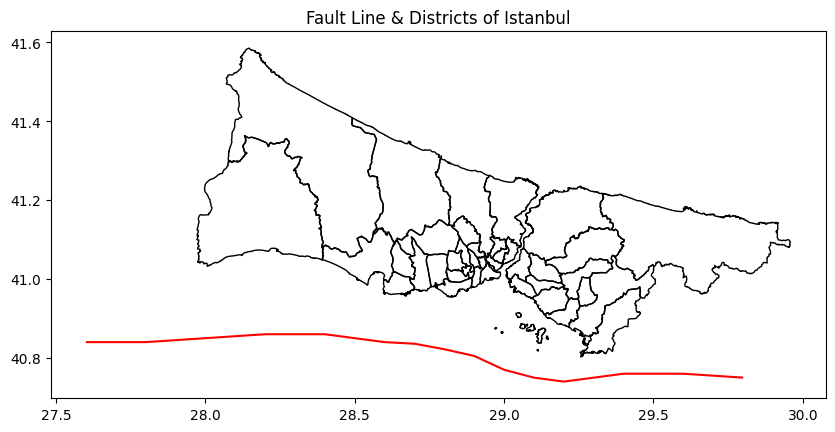

In [61]:
# Coordinates of 16 points on the fault line (longitude, latitude)
fay_noktalari = [
    (27.6, 40.84), (27.8, 40.84), (28.0, 40.85), (28.2, 40.86),
    (28.4, 40.86), (28.5, 40.85), (28.6, 40.840), (28.7, 40.836), (28.8, 40.822), (28.9, 40.805), (29.0, 40.77), (29.1, 40.75),
    (29.2, 40.74), (29.4, 40.76), (29.6, 40.76), (29.8, 40.75),
]

fay_hatti = LineString(fay_noktalari)

# to see the result
fig, ax = plt.subplots(figsize=(10, 10))
geo_df.plot(ax=ax, edgecolor="black", facecolor="none")
gpd.GeoSeries([fay_hatti], crs="EPSG:4326").plot(ax=ax, color="red")
plt.title("Fault Line & Districts of Istanbul")
plt.show()

In [62]:
geo_df_metrik = geo_df.to_crs(epsg=3857)
fay_hatti_metrik = gpd.GeoSeries(fay_hatti, crs="EPSG:4326").to_crs(epsg=3857)[0]

geo_df_metrik["Merkez"] = geo_df_metrik.geometry.centroid

def en_kisa_uzaklik(geometri):
    if geometri is None:
        return None
    try:
        nearest_geom = nearest_points(geometri, fay_hatti_metrik)[1]
        return geometri.distance(nearest_geom)
    except:
        return None

geo_df_metrik["Fay_Uzaklik_Metre"] = geo_df_metrik["Merkez"].apply(en_kisa_uzaklik)

def fay_skoru_hesapla(uzaklik):
    if pd.isnull(uzaklik):
        return 0.0
    elif uzaklik <= 20000:
        return 1.0
    elif uzaklik <= 25000:
        return 0.9
    elif uzaklik <= 30000:
        return 0.8
    elif uzaklik <= 35000:
        return 0.7
    elif uzaklik <= 40000:
        return 0.6
    elif uzaklik <= 45000:
        return 0.5
    elif uzaklik <= 50000:
        return 0.4
    elif uzaklik <= 55000:
        return 0.3
    elif uzaklik <= 60000:
        return 0.2
    elif uzaklik <= 65000:
        return 0.1
    elif uzaklik <= 70000:
        return 0.0

geo_df_metrik["FAY_SKORU"] = geo_df_metrik["Fay_Uzaklik_Metre"].apply(fay_skoru_hesapla)

First, I converted to the metric system and then calculated the district center coordinates. Then, I prepared the distances to the fault line and the risk score.

In [63]:
#districts names were not correct so i changed them

geo_df_metrik["display_name"] = geo_df_metrik["display_name"] \
    .replace("Adalar, İstanbul, Marmara Bölgesi, Türkiye", "ADALAR") \
    .replace("Küçükçekmece, İstanbul, Marmara Bölgesi, 34290, Türkiye", "KUCUKCEKMECE") \
    .replace("Beşiktaş, İstanbul, Marmara Bölgesi, 34022, Türkiye", "BESIKTAS") \
    .replace("Bahçelievler, İstanbul, Marmara Bölgesi, 34180, Türkiye", "BAHCELIEVLER") \
    .replace("Beylikdüzü, İstanbul, Marmara Bölgesi, Türkiye", "BEYLIKDUZU") \
    .replace("Bakırköy, İstanbul, Marmara Bölgesi, 34147, Türkiye", "BAKIRKOY") \
    .replace("Bayrampaşa, İstanbul, Marmara Bölgesi, Türkiye", "BAYRAMPASA") \
    .replace("Esenyurt, İstanbul, Marmara Bölgesi, Türkiye", "ESENYURT") \
    .replace("Avcılar, İstanbul, Marmara Bölgesi, Türkiye", "AVCILAR") \
    .replace("Sultangazi, İstanbul, Marmara Bölgesi, Türkiye", "SULTANGAZI") \
    .replace("Başakşehir, İstanbul, Marmara Bölgesi, Türkiye", "BASAKSEHIR") \
    .replace("Esenler, İstanbul, Marmara Bölgesi, Türkiye", "ESENLER") \
    .replace("Eyüpsultan, İstanbul, Marmara Bölgesi, Türkiye", "EYUPSULTAN") \
    .replace("Bağcılar, İstanbul, Marmara Bölgesi, Türkiye", "BAGCILAR") \
    .replace("Arnavutköy, İstanbul, Marmara Bölgesi, 34275, Türkiye", "ARNAVUTKOY") \
    .replace("Gaziosmanpaşa, İstanbul, Marmara Bölgesi, Türkiye", "GAZIOSMANPASA") \
    .replace("Güngören, İstanbul, Marmara Bölgesi, 34164, Türkiye", "GUNGOREN") \
    .replace("Zeytinburnu, İstanbul, Marmara Bölgesi, 34025, Türkiye", "ZEYTINBURNU") \
    .replace("Fatih, İstanbul, Marmara Bölgesi, Türkiye", "FATIH") \
    .replace("Beyoğlu, İstanbul, Marmara Bölgesi, 34421, Türkiye", "BEYOGLU") \
    .replace("Sarıyer, İstanbul, Marmara Bölgesi, 34450, Türkiye", "SARIYER") \
    .replace("Kağıthane, İstanbul, Marmara Bölgesi, Türkiye", "KAGITHANE") \
    .replace("Şişli, İstanbul, Marmara Bölgesi, Türkiye", "SISLI") \
    .replace("Üsküdar, İstanbul, Marmara Bölgesi, Türkiye", "USKUDAR") \
    .replace("Ümraniye, İstanbul, Marmara Bölgesi, Türkiye", "UMRANIYE") \
    .replace("Beykoz, İstanbul, Marmara Bölgesi, 34820, Türkiye", "BEYKOZ") \
    .replace("Maltepe, İstanbul, Marmara Bölgesi, 34844, Türkiye", "MALTEPE") \
    .replace("Kadıköy, İstanbul, Marmara Bölgesi, Türkiye", "KADIKOY") \
    .replace("Ataşehir, İstanbul, Marmara Bölgesi, Türkiye", "ATASEHIR") \
    .replace("Sancaktepe, İstanbul, Marmara Bölgesi, 34887, Türkiye", "SANCAKTEPE") \
    .replace("Sultanbeyli, İstanbul, Marmara Bölgesi, 34920, Türkiye", "SULTANBEYLI") \
    .replace("Kartal, İstanbul, Marmara Bölgesi, 34860, Türkiye", "KARTAL") \
    .replace("Çekmeköy, İstanbul, Marmara Bölgesi, Türkiye", "CEKMEKOY") \
    .replace("Tuzla, İstanbul, Marmara Bölgesi, Türkiye", "TUZLA") \
    .replace("Pendik, İstanbul, Marmara Bölgesi, 34890, Türkiye", "PENDIK") \
    .replace("Çatalca, İstanbul, Marmara Bölgesi, Türkiye", "CATALCA") \
    .replace("Silivri, İstanbul, Marmara Bölgesi, Türkiye", "SILIVRI") \
    .replace("Büyükçekmece, İstanbul, Marmara Bölgesi, 34500, Türkiye", "BUYUKCEKMECE") \
    .replace("Şile, İstanbul, Marmara Bölgesi, Türkiye", "SILE")

In [64]:
geo_df_metrik[["display_name", "Fay_Uzaklik_Metre", "FAY_SKORU"]].head()

,display_name,Fay_Uzaklik_Metre,FAY_SKORU
0,ADALAR,17092.455574,1.0
1,KUCUKCEKMECE,29035.130744,0.8
2,BESIKTAS,41439.649052,0.5
3,BAHCELIEVLER,27691.068029,0.8
4,BEYLIKDUZU,21611.450394,0.9


In [65]:
geo_df_metrik["İlçe"] = geo_df_metrik["display_name"]

In [66]:
ilce_koord_df = ilce_koord_df.merge(
    geo_df_metrik[["İlçe", "FAY_SKORU"]],
    on="İlçe", how="left"
)

In [67]:
ilce_koord_df[["İlçe", "FAY_SKORU"]].head(10)

,İlçe,FAY_SKORU
0,ADALAR,1.0
1,ARNAVUTKOY,0.2
2,ATASEHIR,0.7
3,AVCILAR,0.8
4,BAGCILAR,0.7
5,BAHCELIEVLER,0.8
6,BAKIRKOY,0.9
7,BASAKSEHIR,0.6
8,BAYRAMPASA,0.6
9,BESIKTAS,0.5


In [68]:
# rakım means altitude
rakim_df=pd.read_csv("../data/rakim.csv")

In [69]:
rakim_df = rakim_df[rakim_df["İlçe"] != "CENGELKOY"]

In [70]:
rakim_df = pd.concat([
    rakim_df,
    pd.DataFrame([["SILE", 126, 0.4]], columns=rakim_df.columns)
], ignore_index=True)

In [71]:
rakim_df.loc[len(rakim_df.index)] = ["ZEYTINBURNU", 33, 0.8]
rakim_df = rakim_df.reset_index(drop=True)

In [72]:
rakim_df = rakim_df.drop(rakim_df[rakim_df["İlçe"] == "ZEYTINBURNU"].index[1])
rakim_df = rakim_df.reset_index(drop=True)

I fixed district problems

In [73]:
#normalize
rakim_df["Rakım_Skoru_Normalize"] = (
    rakim_df["Rakım Skoru"] - rakim_df["Rakım Skoru"].min()
) / (
    rakim_df["Rakım Skoru"].max() - rakim_df["Rakım Skoru"].min()
)

In [74]:
rakim_df.head()

,İlçe,Rakım,Rakım Skoru,Rakım_Skoru_Normalize
0,ADALAR,27,0.8,0.666667
1,ARNAVUTKOY,89,0.6,0.333333
2,ATASEHIR,80,0.6,0.333333
3,AVCILAR,32,0.8,0.666667
4,BAGCILAR,66,0.6,0.333333


In [75]:
ilce_koord_df = ilce_koord_df.merge(
    rakim_df[["İlçe", "Rakım_Skoru_Normalize"]], on="İlçe", how="left"
)

In [76]:
ilce_koord_df[["İlçe", "Etki_Skoru_Normalize", "Bina_Yasi_Skoru_Normalize", "Nufus_Yogunlugu_Normalize", "Zemin_Skoru_Normalize","Yesilsiz_Alan_Skoru_Std", "Rakım_Skoru_Normalize"]].head()

,İlçe,Etki_Skoru_Normalize,Bina_Yasi_Skoru_Normalize,Nufus_Yogunlugu_Normalize,Zemin_Skoru_Normalize,Yesilsiz_Alan_Skoru_Std,Rakım_Skoru_Normalize
0,ADALAR,1.000000,0.802879,0.052559,0.0000,-0.996928,0.666667
1,ARNAVUTKOY,0.149831,0.188041,0.007127,0.5625,-0.996928,0.333333
2,ATASEHIR,0.574028,0.443682,0.201399,0.1250,-0.276924,0.333333
3,AVCILAR,0.603023,0.282375,0.126038,0.6250,0.443079,0.666667
4,BAGCILAR,0.531294,0.462936,0.390476,0.9250,1.163082,0.333333


In [77]:
# Infrastructure data
altyapi_df=pd.read_csv("../data/hastane_itfaiye.csv")

In [78]:
altyapi_df['ALTYAPI_SKORU'] = (altyapi_df['Nüfus/Hastane'] * 0.5) + (altyapi_df['Nüfus/Itfaiye'] * 0.5)

In [79]:
# +1 to avoid log(0) error for small numbers
altyapi_df['ALTYAPI_SKORU_LOG'] = np.log1p(altyapi_df['ALTYAPI_SKORU'])

In [80]:
# normalize
altyapi_df["Altyapi_Skoru_Normalize"] = (
    altyapi_df["ALTYAPI_SKORU_LOG"] - altyapi_df["ALTYAPI_SKORU_LOG"].min()
) / (
    altyapi_df["ALTYAPI_SKORU_LOG"].max() - altyapi_df["ALTYAPI_SKORU_LOG"].min()
)

In [81]:
altyapi_df.head()

,İlçe,Hastane,Itfaiye,İlçe Nüfus,Nüfus/Hastane,Nüfus/Itfaiye,ALTYAPI_SKORU,ALTYAPI_SKORU_LOG,Altyapi_Skoru_Normalize
0,ADALAR,3,5,48366,16122.000000,9673.2,12897.600000,9.464874,0.000000
1,ARNAVUTKOY,3,5,348464,116154.666667,69692.8,92923.733333,11.439545,0.606439
2,ATASEHIR,11,1,414866,37715.090909,414866.0,226290.545455,12.329579,0.879777
3,AVCILAR,7,1,440534,62933.428571,440534.0,251733.714286,12.436131,0.912500
4,BAGCILAR,15,2,713954,47596.933333,356977.0,202286.966667,12.217448,0.845340


In [82]:
ilce_koord_df = ilce_koord_df.merge(
    altyapi_df[["İlçe", "Altyapi_Skoru_Normalize"]], on="İlçe", how="left"
)

In [83]:
ilce_koord_df[["İlçe", "Etki_Skoru_Normalize", "Rakım_Skoru_Normalize", "Nufus_Yogunlugu_Normalize", "Bina_Yogunlugu_Normalize", "Bina_Yasi_Skoru_Normalize", "Kat_Skoru_Normalize", "Zemin_Skoru_Normalize", "Yesilsiz_Alan_Skoru_Std", "Altyapi_Skoru_Normalize"]].head()

,İlçe,Etki_Skoru_Normalize,Rakım_Skoru_Normalize,Nufus_Yogunlugu_Normalize,Bina_Yogunlugu_Normalize,Bina_Yasi_Skoru_Normalize,Kat_Skoru_Normalize,Zemin_Skoru_Normalize,Yesilsiz_Alan_Skoru_Std,Altyapi_Skoru_Normalize
0,ADALAR,1.000000,0.666667,0.052559,0.122649,0.802879,0.023521,0.0000,-0.996928,0.000000
1,ARNAVUTKOY,0.149831,0.333333,0.007127,0.008522,0.188041,0.099636,0.5625,-0.996928,0.606439
2,ATASEHIR,0.574028,0.333333,0.201399,0.236889,0.443682,0.424470,0.1250,-0.276924,0.879777
3,AVCILAR,0.603023,0.666667,0.126038,0.133676,0.282375,0.458804,0.6250,0.443079,0.912500
4,BAGCILAR,0.531294,0.333333,0.390476,0.413262,0.462936,0.673080,0.9250,1.163082,0.845340


## Models

In [85]:
# I uploaded the Istanbul Municipality's estimated loss of life data.
tahmin_verisi = pd.read_csv("../data/Istanbul_Ilceler_Tahmini_2024.csv")

In [86]:
ilce_koord_df.head()

,İlçe,Latitude,Longitude,Etki_Skoru,Etki_Skoru_Normalize,Bina_Yasi_Skoru,Bina_Yasi_Skoru_Normalize,Kat_Skoru,Kat_Skoru_Normalize,Nüfus_2024,Yuzolcumu_km2,Nufus_Yogunlugu,Nufus_Yogunlugu_Normalize,Bina_Yogunlugu_Skor,Bina_Yogunlugu_Normalize,Zemin_Skoru_Normalize,Yesilsiz_Alan_Skoru_Std,FAY_SKORU,Rakım_Skoru_Normalize,Altyapi_Skoru_Normalize
0,ADALAR,40.8708,29.1186,19.287395,1.000000,0.818067,0.802879,0.114891,0.023521,48366,11.05,4377.013575,0.052559,578.552036,0.122649,0.0000,-0.996928,1.0,0.666667,0.000000
1,ARNAVUTKOY,41.1853,28.7392,12.187914,0.149831,0.582164,0.188041,0.140672,0.099636,348464,506.55,687.916297,0.007127,63.055967,0.008522,0.5625,-0.996928,0.2,0.333333,0.606439
2,ATASEHIR,40.9916,29.1270,15.730241,0.574028,0.680249,0.443682,0.250694,0.424470,414866,25.20,16462.936508,0.201399,1094.563492,0.236889,0.1250,-0.276924,0.7,0.333333,0.879777
3,AVCILAR,40.9796,28.7224,15.972370,0.603023,0.618358,0.282375,0.262323,0.458804,440534,42.59,10343.601784,0.126038,628.363466,0.133676,0.6250,0.443079,0.8,0.666667,0.912500
4,BAGCILAR,41.0390,28.8567,15.373387,0.531294,0.687636,0.462936,0.334900,0.673080,713954,22.44,31816.131907,0.390476,1891.221034,0.413262,0.9250,1.163082,0.7,0.333333,0.845340


In [87]:
tahmin_verisi = tahmin_verisi.rename(columns={"ILCE": "İlçe"})
birlesik_df = ilce_koord_df.merge(tahmin_verisi[["İlçe", "Tahmini_Can_Kaybi"]], on="İlçe")

In [88]:
X = ilce_koord_df[[
    "Etki_Skoru_Normalize",
    "FAY_SKORU",
    "Rakım_Skoru_Normalize",
    "Nufus_Yogunlugu_Normalize",
    "Bina_Yogunlugu_Normalize",
    "Bina_Yasi_Skoru_Normalize",
    "Kat_Skoru_Normalize",
    "Yesilsiz_Alan_Skoru_Std",
    "Altyapi_Skoru_Normalize"
]]

y = birlesik_df["Tahmini_Can_Kaybi"]


# x: features 
# y: estimated loss of life

In [89]:
print(birlesik_df["Tahmini_Can_Kaybi"].dtype)

int64


In [90]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X, y)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [91]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

y_pred = model.predict(X)

print("R2 Skoru:", r2_score(y, y_pred))
print("MAE:", mean_absolute_error(y, y_pred))
print("RMSE:", mean_squared_error(y, y_pred) ** 0.5)

R2 Skoru: 0.658383198626814
MAE: 250.21347780290185
RMSE: 329.01764405540723


In [92]:
for feature, coef in zip(X.columns, model.coef_):
    print(f"{feature}: {coef:.4f}")

Etki_Skoru_Normalize: 197.7377
FAY_SKORU: 174.1920
Rakım_Skoru_Normalize: -135.8454
Nufus_Yogunlugu_Normalize: 326.1542
Bina_Yogunlugu_Normalize: 195.6945
Bina_Yasi_Skoru_Normalize: 232.5470
Kat_Skoru_Normalize: 724.3184
Yesilsiz_Alan_Skoru_Std: -203.3563
Altyapi_Skoru_Normalize: 1580.7230


In [93]:
y = pd.cut(birlesik_df["Tahmini_Can_Kaybi"], bins=[0, 500, 900, np.inf],
           labels=["Düşük", "Orta", "Yüksek"])
#low, medium, high

In [94]:
X.head()

,Etki_Skoru_Normalize,FAY_SKORU,Rakım_Skoru_Normalize,Nufus_Yogunlugu_Normalize,Bina_Yogunlugu_Normalize,Bina_Yasi_Skoru_Normalize,Kat_Skoru_Normalize,Yesilsiz_Alan_Skoru_Std,Altyapi_Skoru_Normalize
0,1.000000,1.0,0.666667,0.052559,0.122649,0.802879,0.023521,-0.996928,0.000000
1,0.149831,0.2,0.333333,0.007127,0.008522,0.188041,0.099636,-0.996928,0.606439
2,0.574028,0.7,0.333333,0.201399,0.236889,0.443682,0.424470,-0.276924,0.879777
3,0.603023,0.8,0.666667,0.126038,0.133676,0.282375,0.458804,0.443079,0.912500
4,0.531294,0.7,0.333333,0.390476,0.413262,0.462936,0.673080,1.163082,0.845340


In [98]:
y.head()

0     Düşük
1      Orta
2    Yüksek
3    Yüksek
4    Yüksek
Name: Tahmini_Can_Kaybi, dtype: category
Categories (3, object): ['Düşük' < 'Orta' < 'Yüksek']

In [99]:
y.value_counts()

Tahmini_Can_Kaybi
Yüksek    19
Orta      13
Düşük      7
Name: count, dtype: int64

In [ ]:
# Test

In [120]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [121]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=42, stratify=y
)

In [122]:
# Test - Logistic Regression

In [123]:
# training the model
log_model = LogisticRegression(max_iter=1000, random_state=42)
log_model.fit(X_train, y_train)

# predict with test model
y_pred = log_model.predict(X_test)

# class names
target_names = label_encoder.classes_

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=target_names))

[[2 0 1]
 [0 2 3]
 [0 0 8]]
              precision    recall  f1-score   support

       Düşük       1.00      0.67      0.80         3
        Orta       1.00      0.40      0.57         5
      Yüksek       0.67      1.00      0.80         8

    accuracy                           0.75        16
   macro avg       0.89      0.69      0.72        16
weighted avg       0.83      0.75      0.73        16



In [124]:
# Test - Decision Tree

In [125]:
model = DecisionTreeClassifier(random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

target_names = label_encoder.classes_

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=target_names))

[[2 1 0]
 [1 3 1]
 [1 3 4]]
              precision    recall  f1-score   support

       Düşük       0.50      0.67      0.57         3
        Orta       0.43      0.60      0.50         5
      Yüksek       0.80      0.50      0.62         8

    accuracy                           0.56        16
   macro avg       0.58      0.59      0.56        16
weighted avg       0.63      0.56      0.57        16



In [126]:
# Test - Random Forest

In [127]:
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

[[2 1 0]
 [0 4 1]
 [0 2 6]]
              precision    recall  f1-score   support

       Düşük       1.00      0.67      0.80         3
        Orta       0.57      0.80      0.67         5
      Yüksek       0.86      0.75      0.80         8

    accuracy                           0.75        16
   macro avg       0.81      0.74      0.76        16
weighted avg       0.79      0.75      0.76        16



In [128]:
# Master Datas

In [129]:
#Logistic Regression

In [130]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# training the model
log_model = LogisticRegression(max_iter=1000, random_state=42)
log_model.fit(X, y_encoded)

# make predictions with master data
y_pred_encoded = log_model.predict(X)

# Class names (low, medium, high)
target_names = label_encoder.classes_

y_pred = label_encoder.inverse_transform(y_pred_encoded)

for i, pred in enumerate (y_pred):
    print(f"{i+1}. İlçe Tahmini: {pred}")

1. İlçe Tahmini: Düşük
2. İlçe Tahmini: Orta
3. İlçe Tahmini: Yüksek
4. İlçe Tahmini: Yüksek
5. İlçe Tahmini: Yüksek
6. İlçe Tahmini: Yüksek
7. İlçe Tahmini: Yüksek
8. İlçe Tahmini: Orta
9. İlçe Tahmini: Orta
10. İlçe Tahmini: Orta
11. İlçe Tahmini: Düşük
12. İlçe Tahmini: Yüksek
13. İlçe Tahmini: Orta
14. İlçe Tahmini: Düşük
15. İlçe Tahmini: Düşük
16. İlçe Tahmini: Orta
17. İlçe Tahmini: Yüksek
18. İlçe Tahmini: Yüksek
19. İlçe Tahmini: Yüksek
20. İlçe Tahmini: Orta
21. İlçe Tahmini: Yüksek
22. İlçe Tahmini: Yüksek
23. İlçe Tahmini: Yüksek
24. İlçe Tahmini: Orta
25. İlçe Tahmini: Yüksek
26. İlçe Tahmini: Yüksek
27. İlçe Tahmini: Yüksek
28. İlçe Tahmini: Yüksek
29. İlçe Tahmini: Yüksek
30. İlçe Tahmini: Orta
31. İlçe Tahmini: Düşük
32. İlçe Tahmini: Orta
33. İlçe Tahmini: Yüksek
34. İlçe Tahmini: Düşük
35. İlçe Tahmini: Orta
36. İlçe Tahmini: Yüksek
37. İlçe Tahmini: Yüksek
38. İlçe Tahmini: Yüksek
39. İlçe Tahmini: Yüksek


In [131]:
#DECISION TREE

In [132]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

tree_model = DecisionTreeClassifier(random_state=42)
tree_model.fit(X, y_encoded)

# make predictions with master data
y_pred_tree_encoded = tree_model.predict(X)
y_pred_tree = label_encoder.inverse_transform(y_pred_tree_encoded)

for i, pred in enumerate(y_pred_tree):
    print(f"{i+1}. İlçe Tahmini (DT): {pred}")

ilce_koord_df["Risk_Tahmini_DT"] = y_pred_tree

1. İlçe Tahmini (DT): Düşük
2. İlçe Tahmini (DT): Orta
3. İlçe Tahmini (DT): Yüksek
4. İlçe Tahmini (DT): Yüksek
5. İlçe Tahmini (DT): Yüksek
6. İlçe Tahmini (DT): Yüksek
7. İlçe Tahmini (DT): Orta
8. İlçe Tahmini (DT): Orta
9. İlçe Tahmini (DT): Orta
10. İlçe Tahmini (DT): Orta
11. İlçe Tahmini (DT): Düşük
12. İlçe Tahmini (DT): Yüksek
13. İlçe Tahmini (DT): Orta
14. İlçe Tahmini (DT): Düşük
15. İlçe Tahmini (DT): Düşük
16. İlçe Tahmini (DT): Orta
17. İlçe Tahmini (DT): Yüksek
18. İlçe Tahmini (DT): Yüksek
19. İlçe Tahmini (DT): Orta
20. İlçe Tahmini (DT): Yüksek
21. İlçe Tahmini (DT): Yüksek
22. İlçe Tahmini (DT): Orta
23. İlçe Tahmini (DT): Yüksek
24. İlçe Tahmini (DT): Yüksek
25. İlçe Tahmini (DT): Yüksek
26. İlçe Tahmini (DT): Yüksek
27. İlçe Tahmini (DT): Yüksek
28. İlçe Tahmini (DT): Yüksek
29. İlçe Tahmini (DT): Yüksek
30. İlçe Tahmini (DT): Orta
31. İlçe Tahmini (DT): Düşük
32. İlçe Tahmini (DT): Orta
33. İlçe Tahmini (DT): Yüksek
34. İlçe Tahmini (DT): Düşük
35. İlçe Tahmini 

In [133]:
#RANDOM FOREST

In [134]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X, y_encoded)

y_pred_rf_encoded = rf_model.predict(X)
y_pred_rf = label_encoder.inverse_transform(y_pred_rf_encoded)

for i, pred in enumerate(y_pred_rf):
    print(f"{i+1}. İlçe Tahmini (RF): {pred}")

ilce_koord_df["Risk_Tahmini_RF"] = y_pred_rf

1. İlçe Tahmini (RF): Düşük
2. İlçe Tahmini (RF): Orta
3. İlçe Tahmini (RF): Yüksek
4. İlçe Tahmini (RF): Yüksek
5. İlçe Tahmini (RF): Yüksek
6. İlçe Tahmini (RF): Yüksek
7. İlçe Tahmini (RF): Orta
8. İlçe Tahmini (RF): Orta
9. İlçe Tahmini (RF): Orta
10. İlçe Tahmini (RF): Orta
11. İlçe Tahmini (RF): Düşük
12. İlçe Tahmini (RF): Yüksek
13. İlçe Tahmini (RF): Orta
14. İlçe Tahmini (RF): Düşük
15. İlçe Tahmini (RF): Düşük
16. İlçe Tahmini (RF): Orta
17. İlçe Tahmini (RF): Yüksek
18. İlçe Tahmini (RF): Yüksek
19. İlçe Tahmini (RF): Orta
20. İlçe Tahmini (RF): Yüksek
21. İlçe Tahmini (RF): Yüksek
22. İlçe Tahmini (RF): Orta
23. İlçe Tahmini (RF): Yüksek
24. İlçe Tahmini (RF): Yüksek
25. İlçe Tahmini (RF): Yüksek
26. İlçe Tahmini (RF): Yüksek
27. İlçe Tahmini (RF): Yüksek
28. İlçe Tahmini (RF): Yüksek
29. İlçe Tahmini (RF): Yüksek
30. İlçe Tahmini (RF): Orta
31. İlçe Tahmini (RF): Düşük
32. İlçe Tahmini (RF): Orta
33. İlçe Tahmini (RF): Yüksek
34. İlçe Tahmini (RF): Düşük
35. İlçe Tahmini 

## Visualisierung

In [ ]:
import shap
import matplotlib.pyplot as plt
from lime import lime_tabular
import numpy as np
from IPython.core.display import HTML
from IPython.display import display

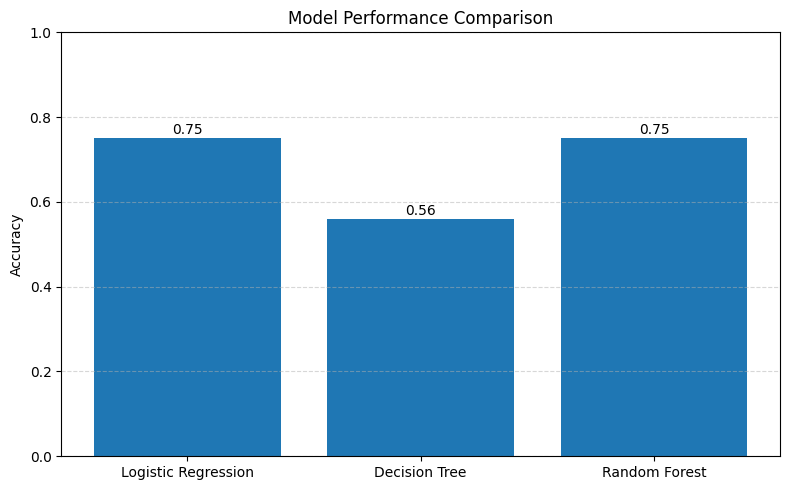

In [135]:
models = ['Logistic Regression', 'Decision Tree', 'Random Forest']
accuracies = [0.75, 0.56, 0.75]

plt.figure(figsize=(8, 5))
bars = plt.bar(models, accuracies)

# Renk ve etiket
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.01, f'{yval:.2f}', ha='center')

plt.ylim(0, 1)
plt.ylabel('Accuracy')
plt.title('Model Performance Comparison')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [136]:
#SHAP

I used SHAP to understand the global impact of each variable across all districts.

Sınıf: Düşük


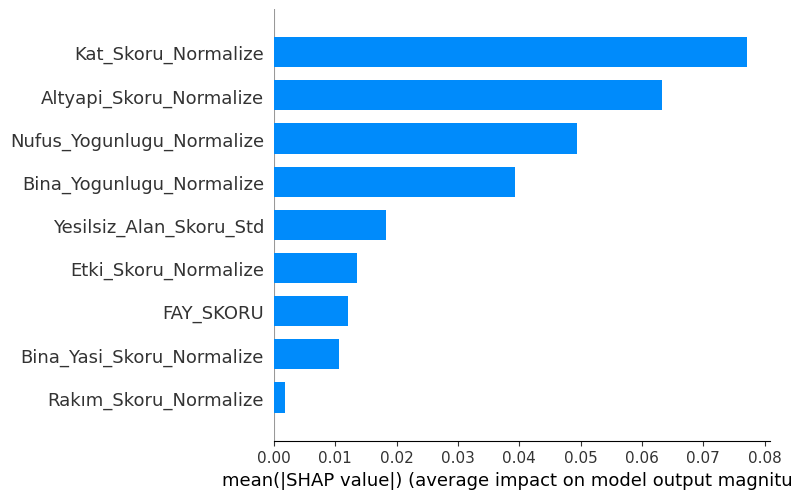

Sınıf: Orta


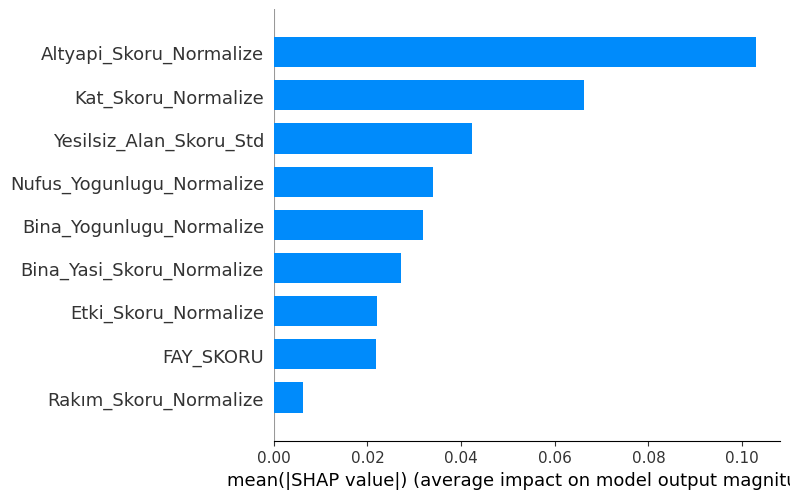

Sınıf: Yüksek


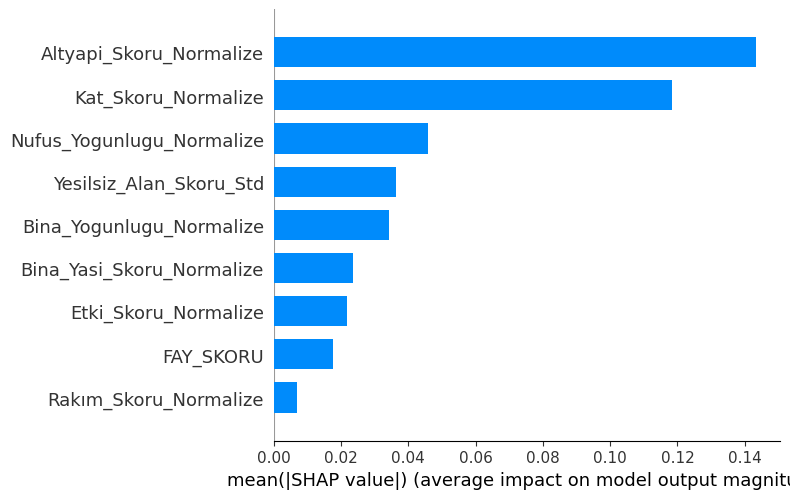

In [137]:
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X)

# fix the size
if shap_values.shape[-1] == 3 and shap_values.shape[0] != 3:
    shap_values = np.moveaxis(shap_values, -1, 0)

for i, label in enumerate(["Düşük", "Orta", "Yüksek"]):
    print(f"Sınıf: {label}")
    shap.summary_plot(shap_values[i], X, plot_type="bar")

In this code block, I analyzed the extent to which features influenced the Random Forest model's predictions using the SHAP method. By visualizing the most influential variables for each class (Low, Medium, High) using a bar chart, I aimed to make the model's decisions more transparent and interpretable.

In [138]:
#LIME

I used LIME to explain specific district-level predictions.

In [108]:
explainer = lime_tabular.LimeTabularExplainer(
    training_data=np.array(X),
    feature_names=X.columns.tolist(),
    class_names=["Düşük", "Orta", "Yüksek"],  # y sınıfların sıralaması neyse
    mode="classification"
)

# index for districts
i = 0

# Açıklama al
exp = explainer.explain_instance(
    data_row=X.iloc[i],
    predict_fn=rf_model.predict_proba
)

# to write name of the district
ilce_ismi = ilce_koord_df.loc[i, "İlçe"]
print(f"Bu analiz şu ilçeye ait: {ilce_ismi}")

# to see HTML output
html_output = exp.as_html()
display(HTML(html_output))

Bu analiz şu ilçeye ait: ADALAR


C:\Users\cihan\PycharmProjects\PythonProject\PythonProject-almanya-\.venv\Lib\site-packages\lime\discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
C:\Users\cihan\PycharmProjects\PythonProject\PythonProject-almanya-\.venv\Lib\site-packages\lime\discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
C:\Users\cihan\PycharmProjects\PythonProject\PythonProject-almanya-\.venv\Lib\site-packages\lime\lime_tabular.py:544: FutureWarning: Series.__getitem__ treating keys as positions is d

<Axes: >

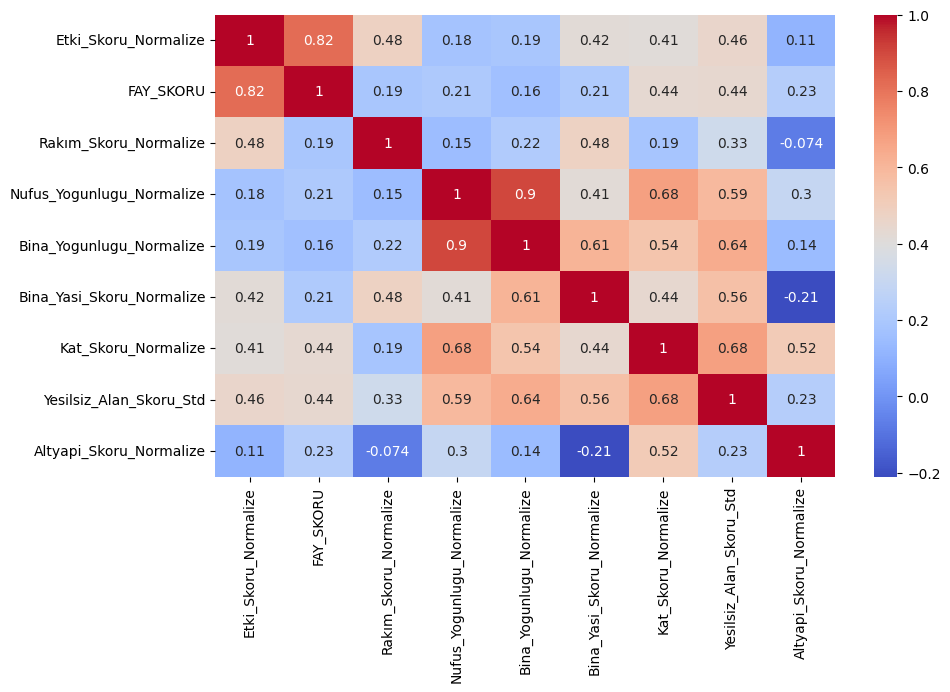

In [109]:
plt.figure(figsize=(10,6))
sns.heatmap(X.corr(), annot=True, cmap='coolwarm')

In [110]:
# Creating a Map

I created a map to show risk color of the districts

In [111]:
# Risk class estimates
risk_sinifi = rf_model.predict(X)

# new column to the ilce_koord_df
ilce_koord_df["Risk_Sinifi"] = risk_sinifi

ilce_koord_df[["İlçe", "Risk_Sinifi"]].head()

,İlçe,Risk_Sinifi
0,ADALAR,0
1,ARNAVUTKOY,1
2,ATASEHIR,2
3,AVCILAR,2
4,BAGCILAR,2


In [112]:
geo_df["İlçe"] = geo_df["display_name"].str.extract(r'^([^,]+)').apply(lambda x: x.str.upper())

turkce_cevir = str.maketrans("ÇĞİÖŞÜçğıöşü", "CGIOSUcgiosu")
geo_df["İlçe"] = geo_df["İlçe"].apply(lambda x: x.translate(turkce_cevir))
# turkish alphabet to english

# Merge
birlesik_geo = geo_df.merge(ilce_koord_df[["İlçe", "Risk_Sinifi"]], on="İlçe")

In [113]:
import folium
from folium.features import GeoJson, GeoJsonTooltip

# creating a map
m = folium.Map(location=[41.0082, 28.9784], zoom_start=9)

# Colors
renkler = {
    0: "green",
    1: "orange",
    2: "red"
}

# GeoJSON layer
folium.GeoJson(
    data=birlesik_geo,
    style_function=lambda feature: {
        'fillColor': renkler.get(feature['properties']["Risk_Sinifi"], 'gray'),
        'color': 'black',
        'weight': 1,
        'fillOpacity': 0.6
    },
    tooltip=GeoJsonTooltip(fields=["İlçe", "Risk_Sinifi"]),
    name="Risk Haritası"
).add_to(m)

folium.LayerControl().add_to(m)
m